In [3]:
import tensorflow as tf
import cudf
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [4]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'probability_NN.ipynb'

In [5]:
# Function to configure GPU
def configure_gpu():
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
    # Invalid device or cannot modify virtual devices once initialized.
        pass

# Function to load and preprocess data
def load_and_preprocess_data(filepath, test_size=0.2, random_state=42):
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading data file: {e}")
        return None, None, None, None

    y = df['output_val']
    X = df.drop(['output_val'], axis=1)
    # normalize the data with max-min normalization
    X = (X - X.min()) / (X.max() - X.min())
    y= (y - y.min()) / (y.max() - y.min())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=random_state)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    return X_train, X_test, y_train, y_test
data_file_path = './data/train_data_histogram_longtime_210000_coursegrained.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_file_path)

X_train shape: (1679200, 2)
y_train shape: (1679200,)


In [6]:
#extract R from X_train
R = X_train['R']

def chunked_trapezoidal_integration_tf(R, y_pred, chunk_size=10000):
    # Convert R and y_pred to the same type (float32, for example)
    R = tf.cast(R, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Sort the data without duplicating large arrays
    sorted_indices = tf.argsort(R, axis=0)
    integral_sum = tf.constant(0.0, dtype=tf.float32)

    # Process in chunks
    for start_idx in range(0, len(R), chunk_size):
        end_idx = start_idx + chunk_size
        R_chunk = tf.gather(R, sorted_indices[start_idx:end_idx], axis=0)
        y_pred_chunk = tf.gather(y_pred, sorted_indices[start_idx:end_idx], axis=0)

        # Compute the integral for this chunk using trapezoidal rule
        integral_chunk = tf.reduce_sum((R_chunk[1:] - R_chunk[:-1]) * (y_pred_chunk[1:] + y_pred_chunk[:-1]) / 2)
        integral_sum += integral_chunk

    return integral_sum


def custom_loss_with_integral_penalty(y_true, y_pred, R, integral_penalty_weight=0.1):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Calculate integral using chunked trapezoidal integration
    integral = chunked_trapezoidal_integration_tf(R, y_pred)

    # Integral penalty
    integral_penalty = tf.abs(1 - integral)

    # Total loss combining MSE and integral penalty
    total_loss = mse_loss + integral_penalty_weight * integral_penalty

    return total_loss

In [7]:
# Create the neural network model
def create_model(X_train_R, model_type='default', input_shape=(2,)):
    if model_type == 'default':
        model = keras.Sequential([
            keras.layers.Normalization(),
            keras.layers.Dense(120, activation='tanh', input_shape=input_shape, kernel_initializer='glorot_normal'),
            keras.layers.Dropout(wandb.config.dropout_1 if 'dropout_1' in wandb.config else 0.1),
            keras.layers.Normalization(),
            keras.layers.Dense(60, activation='tanh', kernel_initializer='glorot_normal'),
            keras.layers.Dropout(wandb.config.dropout_2 if 'dropout_2' in wandb.config else 0.1),
            keras.layers.Normalization(),
            keras.layers.Dense(30, activation='tanh', kernel_initializer='glorot_normal'),
            keras.layers.Normalization(),
            keras.layers.Dense(1, activation='tanh', kernel_initializer='glorot_normal')
        ])
    elif model_type == 'alt':
        model = keras.Sequential([
                keras.layers.Normalization(),
                keras.layers.Dense(120, activation='relu', input_shape=(1,)),
                keras.layers.Dropout(0.2),
                keras.layers.Normalization(),
                keras.layers.Dense(60, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Normalization(),
                keras.layers.Dense(60, activation='relu'),
                keras.layers.Normalization(),
                keras.layers.Dense(30, activation='relu'),
                keras.layers.Normalization(),
                keras.layers.Dense(1, activation='relu')
        ])
        pass
    else:
        raise ValueError("Invalid model type specified.")
    
    def loss_function(y_true, y_pred):
        return custom_loss_with_integral_penalty(y_true, y_pred, X_train_R)
    
    learning_rate = wandb.config.learning_rate if 'learning_rate' in wandb.config else 0.0001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=loss_function)
    return model
# Train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=8500, validation_split=0.2):
    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                            callbacks=[WandbMetricsLogger(log_freq=5), WandbModelCheckpoint("models")])
        test_loss = model.evaluate(X_test, y_test)
    except Exception as e:
        print(f"Error during training or evaluation: {e}")
        return None, None
    return history, test_loss

In [8]:
def main(model_type='alt'):
    # Initialize wandb
    wandb.init(project="The Nurul Network", name="nov24_2pm", config={
        "dropout_1": 0.2,
        "dropout_2": 0.1,
        "learning_rate": 0.03671,  # Add learning rate here
        "epoch": 100,
        "batch_size": 8500
        # Other wandb configurations can be added here
    })

    configure_gpu()
    data_file_path = './data/train_data_histogram_longtime_210000_coursegrained.csv' # FILE PATH
    X_train, X_test, y_train, y_test = load_and_preprocess_data(data_file_path)

    if X_train is None:
        print("Failed to load data. Exiting.")
        return
    
    X_train_R = X_train['R']

    model = create_model(X_train_R, model_type=model_type, input_shape=X_train.shape[1:])

    history, test_loss = train_and_evaluate_model(model, X_train, y_train, X_test, y_test,
                                                  epochs=wandb.config.epoch,
                                                  batch_size=wandb.config.batch_size)

    if history is not None:
        print(f"Test Loss: {test_loss}")

    wandb.finish()
    
    print("X_train shape: ", X_train.shape)
    # print("y_train shape: ", y_train.shape)
    # print("X_test shape: ", X_test.shape)
    # print("y_test shape: ", y_test.shape)
    # print("Model Summary: ")
    # print(model.summary())

    return history, test_loss, model, X_test, y_test

In [9]:
history, test_loss, model, X_test, y_test = main(model_type='alt')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Network error (ReadTimeout), entering retry loop.


Problem at: /tmp/ipykernel_60872/3918573681.py 3 main


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [19]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

13119/13119 [==============================] - 39s 3ms/step - loss: 0.7578
Test loss: 0.7577913999557495
13119/13119 [==============================] - 26s 2ms/step


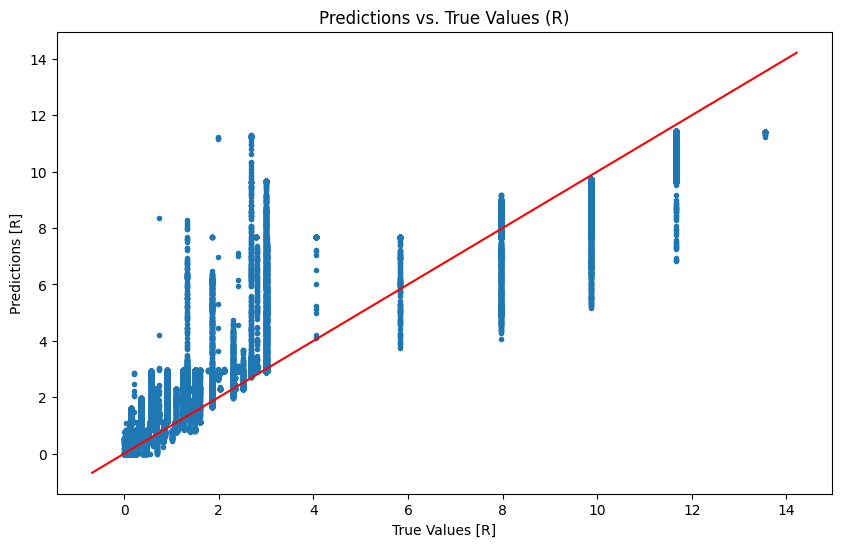

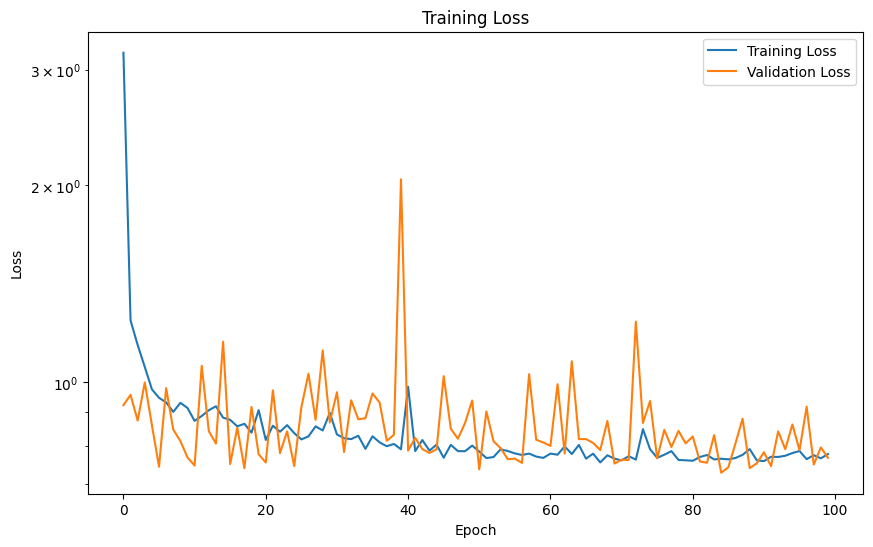

In [20]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test).iloc[:,0], predictions, '.')
# plt.plot(y_test_2d, predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

/tmp/ipykernel_201098/4060361779.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


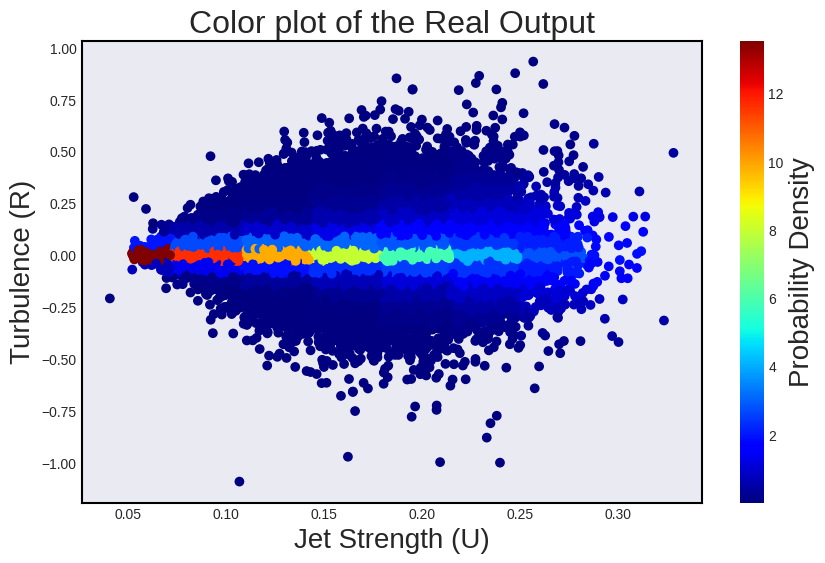

In [21]:
# extract U and R from the test data
U_test = X_test.iloc[:,0]
R_test = X_test.iloc[:,1]
output_test = y_test.iloc[:]

import matplotlib.pyplot as plt

# Set the style to 'seaborn-dark'
plt.style.use('seaborn-dark')

# Initialize the plot
plt.figure(figsize=(10, 6))

# Create the scatter plot
# plt.scatter(U_test, R_test, c=predictions.reshape(-1), cmap='jet')
plt.scatter(U_test, R_test, c=output_test, cmap='jet')

# Set axis labels and title with enhanced font sizes
plt.xlabel('Jet Strength (U)', fontsize=20)
plt.ylabel('Turbulence (R)', fontsize=20)
plt.title('Color plot of the Real Output', fontsize=23)

# Add and label the colorbar with enhanced font size
cbar = plt.colorbar()
cbar.set_label('Probability Density', fontsize=20)

# Modify spines to add borders
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Suppress the axis ticks
# ax.set_xticks([])
# ax.set_yticks([])

plt.show()


/tmp/ipykernel_201098/1854800895.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


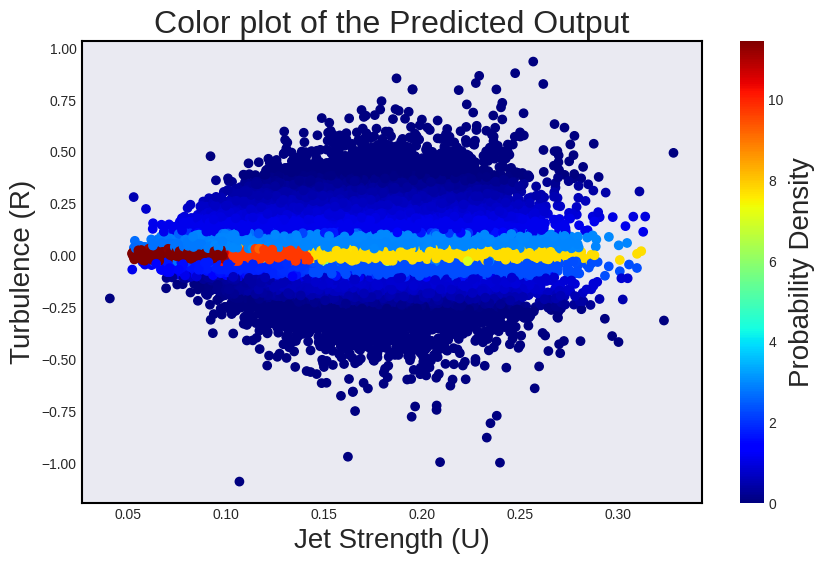

In [22]:
# Set the style to 'seaborn-dark'
plt.style.use('seaborn-dark')

# Initialize the plot
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(U_test, R_test, c=predictions.reshape(-1), cmap='jet')

# Set axis labels and title with enhanced font sizes
plt.xlabel('Jet Strength (U)', fontsize=20)
plt.ylabel('Turbulence (R)', fontsize=20)
plt.title('Color plot of the Predicted Output', fontsize=23)

# Add and label the colorbar with enhanced font size
cbar = plt.colorbar()
cbar.set_label('Probability Density', fontsize=20)

# Modify spines to add borders
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Suppress the axis ticks
# ax.set_xticks([])
# ax.set_yticks([])

plt.show()